In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import random

C:\Users\hl62868\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def scaled_square_dist(lengthscales, X, X2=None):
    X = X / lengthscales
    Xs = tf.reduce_sum(tf.square(X), axis=1)
    
    if X2 is None:
        dist = -2 * tf.matmul(X, X, transpose_b=True)
        dist += tf.reshape(Xs, (-1, 1))  + tf.reshape(Xs, (1, -1))
        return dist
    
    X2 = X2 / lengthscales
    X2s = tf.reduce_sum(tf.square(X2), axis=1)
    dist = -2 * tf.matmul(X, X2, transpose_b=True)
    dist += tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))
    return dist

"""
def rbf(lengthscale,sigma,X,X2=None):
    n,d =X.shape

    cons = tf.constant(1e-4,dtype=tf.float32)
    X = X / lengthscale
    Xs = tf.reduce_sum(tf.square(X), axis=1,keepdims=True)

    temp1 = tf.add(Xs,tf.transpose(Xs))
    temp2 = -2*tf.matmul(X,tf.transpose(X))
    temp3 = tf.add(temp1,temp2)
    temp4 = sigma*tf.exp(-temp3/2)
    
    K = tf.add(temp4,cons*tf.eye(int(n),dtype=tf.float32))

    return K
"""


def rbf(lengthscale,sigma,X,X2=None):
    return sigma*tf.exp(-scaled_square_dist(lengthscale,X,X2) / 2)


In [3]:
def base_conditional(Kmn, Kmm, Knn, f, white=False):
    """
    Given a g1 and g2, and distribution p and q such that
      p(g2) = N(g2;0,Kmm)
      p(g1) = N(g1;0,Knn)
      p(g1|g2) = N(g1;0,Knm)
    And
      q(g2) = N(g2;f,q_sqrt*q_sqrt^T)
    This method computes the mean and (co)variance of
      q(g1) = \int q(g2) p(g1|g2)
    :param Kmn: M x N
    :param Kmm: M x M
    :param Knn: N x N  or  N
    :param f: M x R
    :return: N x R  or R x N x N
    """

    #num_func = tf.shape(f)[1]  # R
    Lm = tf.cholesky(Kmm)

    # Compute the projection matrix A
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)

    # compute the covariance due to the conditioning

    #fvar = Knn - tf.reduce_sum(tf.square(A), 0)
    #fvar = tf.tile(fvar[None, :], [num_func, 1])  # R x N

    # another backsubstitution in the unwhitened case
    if not white:
        A = tf.matrix_triangular_solve(tf.transpose(Lm), A, lower=False)

    # construct the conditional mean
    fmean = tf.matmul(A, f, transpose_a=True)

    #fvar = tf.transpose(fvar)  # N x R

    return fmean#, fvar  # N x R, R x N x N or N x R

In [4]:
def multivariate_normal(x,mu,L):
    """
    Computes the log-density of a multivariate normal.
    :param x  : Dx1 or DxN sample(s) for which we want the density
    :param mu : Dx1 or DxN mean(s) of the normal distribution
    :param L  : DxD Cholesky decomposition of the covariance matrix
    :return p : (1,) or (N,) vector of log densities for each of the N x's and/or mu's
    x and mu are either vectors or matrices. If both are vectors (N,1):
    p[0] = log pdf(x) where x ~ N(mu, LL^T)
    If at least one is a matrix, we assume independence over the *columns*:
    the number of rows must match the size of L. Broadcasting behaviour:
    p[n] = log pdf of:
    x[n] ~ N(mu, LL^T) or x ~ N(mu[n], LL^T) or x[n] ~ N(mu[n], LL^T)
    """
    d = x - mu
    alpha = tf.matrix_triangular_solve(L, d, lower=True)
    num_dims = tf.cast(tf.shape(d)[0], L.dtype)
    p = - 0.5 * tf.reduce_sum(tf.square(alpha), 0)
    p -= 0.5 * num_dims * np.log(2 * np.pi)
    p -= tf.reduce_sum(tf.log(tf.matrix_diag_part(L)))
    return p
    

In [5]:
class GPR():
    
    def __init__(self,X_,Y_):
        self.n,self.d =X_.shape
        
        self.X = tf.constant(X_,dtype=tf.float32)
        self.Y = tf.constant(Y_,dtype=tf.float32)
        
        #self.lengthscale = tf.Variable(np.array([1 for i in range(self.d)]),dtype=tf.float32,name='lengthscale')
        self.sigma = tf.Variable(random.random(),dtype=tf.float32,name='sigma')
        self.lengthscale = tf.random_normal([1,self.d],dtype=tf.float32,name='lengthscale')
        #self.sigma = tf.random_normal([1,0],dtype=tf.float32,name='sigma')
        
        self.likelihood_variance = tf.constant(1e-10,dtype = tf.float32)
        
    def _build_likelihood(self):
        K = rbf(self.lengthscale,self.sigma,self.X)+tf.eye(self.n, dtype=tf.float32) * self.likelihood_variance
        L = tf.cholesky(K)
        logpdf = multivariate_normal(self.Y, 0, L)
        
        return tf.reduce_sum(logpdf)
    
    def objective(self):
        obj = - self._build_likelihood()
        return obj
    
    def optimize(self):
        loss = - self._build_likelihood()
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
        return loss, optimizer
    
    def predict(self,Xnew_):
        Xnew = tf.constant(Xnew_,dtype=tf.float32)
        y = self.Y
        Kmn = rbf(self.lengthscale,self.sigma,self.X,Xnew)
        Kmm_sigma = rbf(self.lengthscale,self.sigma,self.X)+tf.eye(self.n, dtype=tf.float32) * self.likelihood_variance
        Knn = tf.fill(tf.stack([tf.shape(Xnew)[0]]), tf.squeeze(self.sigma))
        f_mean = base_conditional(Kmn, Kmm_sigma, Knn, y,white=False)
        
        return f_mean
        

In [6]:
def train(sess,m):
    #sess.run(tf.global_variables_initializer())
    loss, optimizer = m.optimize()
    sess.run(tf.global_variables_initializer())
    sess.run(optimizer)

In [6]:
def g(x):
    result = []
    for item in x:
        result.append(np.dot(item,np.sin(item)))
    return np.array(result).reshape(-1,1)

In [7]:
# number of training points
num = 5000
# dimension of input data
d = 100

X = np.random.rand(num, d)*1
Y = g(X) + np.random.randn(num,1) * 0.001

X_test = np.random.rand(int(num/20), d)*1
Y_test = g(X_test) + np.random.randn(int(num/20),1) * 0.001

#X = tf.constant(X,dtype=tf.float32)
#Y = tf.constant(Y,dtype=tf.float32)
#X_test = tf.constant(X_test,dtype=tf.float32)

In [8]:
X.shape

(5000, 100)

In [9]:
m = GPR(X,Y)
print(m.n)

5000


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = m.objective()
    optimizer = tf.train.AdamOptimizer(.001)
    minimize = optimizer.minimize(loss)
    sess.run(tf.variables_initializer(optimizer.variables()))
    print("Lengthscale and variance before traing:")
    print(sess.run(m.lengthscale))
    print(sess.run(m.sigma))
    
    print("\nNumber of training points:",X.shape[0])
    print("Start training","at",time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
    start = time.time()
    sess.run(minimize)
    print("Training time:","{:.2f}".format((time.time()-start)/60),"min")
    
    #print()
    #print(optimizer.variables())
    #train(sess,m)
    
    print()
    print("Lengthscale and variance afrer traing:")
    print(sess.run(m.lengthscale))#
    print(sess.run(m.sigma))
    
    pred_train = sess.run(m.predict(X))
    pred_test = sess.run(m.predict(X_test))

Lengthscale and variance before traing:
[[ 0.03247521  1.80073     1.585843    1.2733274  -1.2900414  -0.18748412
   0.97167486 -0.22349952  0.4775196   1.8615371  -0.37863794 -0.26570317
   1.2355932  -0.04794242  2.3294678   0.13739118  0.918546   -1.0011652
  -0.21519792  2.0383048  -1.6645936   1.3986082   0.9333968  -0.6334626
   1.7407638  -1.0301738  -2.0028694  -1.3287133  -0.5679659   0.5673908
   0.6419011   1.178975   -0.51786083  0.20579934 -1.357573    1.5216389
  -0.23703048 -0.21785755 -1.3600526   0.84253025 -1.1216326  -0.46642697
   0.70954704  1.3361639   1.3849596   2.5496447  -0.49657086  0.3613998
  -0.4526454  -0.46553296  0.6150385   1.2216097   1.4232559  -1.0178919
  -0.03682132 -0.4183236  -0.15821639  0.59518653 -0.8904212  -1.6216046
  -0.00720079 -0.61343586 -1.1054192  -1.513813   -1.1492251  -0.38926408
  -1.5344609  -0.83273315 -2.0183332   0.23943992  1.6140903   0.9135884
   0.3160086   1.3949625  -0.1680535  -0.26491988 -0.09364156 -1.7918214
   0.36

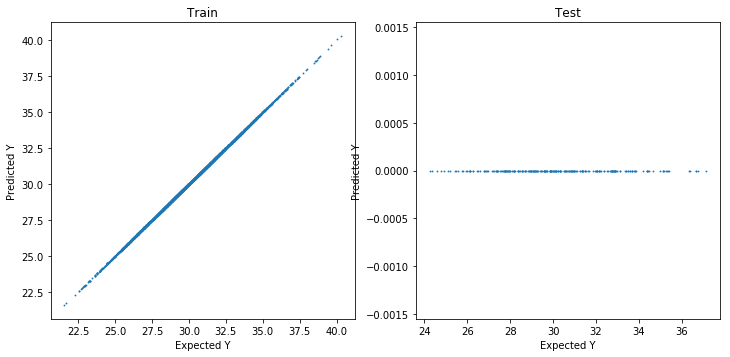

In [11]:
fig = plt.figure(figsize=(12, 12))
f3 = fig.add_subplot(221)
f3.scatter(Y,pred_train,s=0.7)
f3.set_title('Train')
f3.set_xlabel('Expected Y')
f3.set_ylabel('Predicted Y')

f4 = fig.add_subplot(222)
f4.scatter(Y_test,pred_test,s=0.7)
f4.set_title('Test')
f4.set_xlabel('Expected Y')
f4.set_ylabel('Predicted Y')
plt.show()

Tensor("MatMul_25:0", shape=(500, 1), dtype=float32)
